## CLEAN HOMES

In [1]:
import os
from common_functions import *
from helper_modules import CustomBigQuery
os.chdir("../..")
from sibr_module import Logger, CStorage
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)
from src.sibr_market_training import Clean
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
replace = True
dataset = 'homes'
logger = Logger(f'clean{dataset.capitalize()}')
logger.log_level = "DEBUG"
bq = CustomBigQuery(logger=logger, dataset=dataset)
cs = CStorage(logger=logger, bucket_name='sibr-market-bucket')
logger.debug(f'Replace: {replace} | Dataset: {dataset}')
self = Clean(logger=logger, dataset=dataset)

2025-08-27 10:11:42,360 - cleanHomes - INFO - Cloud Logging is disabled. Using local logging to /Users/sigvardbratlie/Documents/Projects/sibr_market_training/logfiles/cleanHomes.log.
2025-08-27 10:11:42,363 - cleanHomes - INFO - BigQuery client initialized with project_id: sibr-market
2025-08-27 10:11:42,365 - cleanHomes - INFO - Google Cloud Storage client initialized with bucket: sibr-market-bucket
2025-08-27 10:11:42,365 - cleanHomes - DEBUG - Replace: True | Dataset: homes
2025-08-27 10:11:42,367 - cleanHomes - INFO - BigQuery client initialized with project_id: sibr-market
2025-08-27 10:11:42,368 - cleanHomes - INFO - Google Cloud Storage client initialized with bucket: sibr-market
2025-08-27 10:11:42,369 - cleanHomes - DEBUG - Dataset: homes | | Replace: False
2025-08-27 10:11:42,369 - cleanHomes - INFO - Clean class initialized.


In [3]:
df_ = bq.read_raw(replace=replace)
geo = bq.read_geonorge()

2025-08-27 10:09:19,249 - cleanHomes - INFO - Reading raw data from dataset: raw.homes
2025-08-27 10:09:36,718 - cleanHomes - INFO - 176875 rader lest fra BigQuery
2025-08-27 10:09:38,574 - cleanHomes - INFO - 5137 rader lest fra BigQuery


## Remove empty feature and missing data

In [47]:
c.logger.debug(f'Length of df before cleaning: {len(df_)}')
c.df = df_
df = c.transform_nan(df_)
df.drop_duplicates(subset=['item_id'], inplace=True)
df = c.rm_empty_features(df)
c.logger.debug(f'Length: {len(df)} | after removing NaN values and duplicates')

2025-08-27 10:33:17,512 - cleanHomes - DEBUG - Length of df before cleaning: 176875
2025-08-27 10:33:17,513 - cleanHomes - DEBUG - Length of df before cleaning: 176875
2025-08-27 10:33:19,452 - cleanHomes - DEBUG - Length: 176875 | after removing columns with >90% missing values
2025-08-27 10:33:19,453 - cleanHomes - DEBUG - Length: 176875 | after removing NaN values and duplicates


## Int and Float data

In [5]:
import re
import ast
def extract_int(x):
    """
    Extracts an integer from a string.

    Args:
        x (str): The input value from which to extract the number.
    Returns:
        int or None: The extracted integer, or None if no valid number can be extracted.

    Examples
        "200.000" : str -> 200000 : int
        "200,000" : str -> 200000 : int
        "200m2" : str -> 200 : int
        "2000,0 : str -> 2000000 : int
        "435,5 kr : srt -> 435500 : int
    """
    if not isinstance(x, str):
        return None
    uten_mellomrom = re.sub(r'\s', '', x)
    match = re.search(r'[\d.,]+', uten_mellomrom)
    if not match:
        return None
    nummer_str = match.group(0)
    has_separator = '.' in nummer_str or ',' in nummer_str
    # Parse to float using similar logic as extract_float
    if ',' in nummer_str and '.' in nummer_str:
        if nummer_str.rfind(',') > nummer_str.rfind('.'):
            nummer_str_parsed = nummer_str.replace('.', '').replace(',', '.')
        else:
            nummer_str_parsed = nummer_str.replace(',', '')
    elif ',' in nummer_str:
        nummer_str_parsed = nummer_str.replace(',', '.')
    else:
        nummer_str_parsed = nummer_str
    try:
        nummer_float = float(nummer_str_parsed)
    except (ValueError, TypeError):
        return None
    if not has_separator:
        if nummer_float.is_integer():
            return int(nummer_float)
        else:
            return None
    else:
        # Multiply by 1000 and round to int
        multiplied = nummer_float * 1000
        return int(round(multiplied))

def extract_float(x):
    """
    Extracts  a float number from a string.

    Args:
        x (str): The input value from which to extract the number.
    Returns:
        float or None: The extracted floating number, or None if no valid number can be extracted.

    Examples
        "200.000" : str -> 200.0 : float
        "200,000" : str -> 200.0 : float
        "200m2" : str -> 200.0 : float
        "2000,0 : str -> 2000.0 : float
        "435,5 kr : srt -> 435.5 : float
            """
    if not isinstance(x, str):
        return None
    uten_mellomrom = re.sub(r'\s', '', x)
    match = re.search(r'[\d.,]+', uten_mellomrom)
    if not match:
        return None
    nummer_str = match.group(0)
    if ',' in nummer_str and '.' in nummer_str:
        if nummer_str.rfind(',') > nummer_str.rfind('.'):
            nummer_str = nummer_str.replace('.', '').replace(',', '.')
        else:
            nummer_str = nummer_str.replace(',', '')
    elif ',' in nummer_str:
        nummer_str = nummer_str.replace(',', '.')
    try:
        return float(nummer_str)
    except (ValueError, TypeError):
        return None

0         ['Gårdsnr', ': ', '186']
1                             None
2           ['Gårdsnr', ': ', '9']
3                             None
4          ['Gårdsnr', ': ', '20']
                    ...           
176870     ['Gårdsnr', ': ', '36']
176871    ['Gårdsnr', ': ', '144']
176872     ['Gårdsnr', ': ', '62']
176873     ['Gårdsnr', ': ', '61']
176874    ['Gårdsnr', ': ', '185']
Name: cadastral_num, Length: 176875, dtype: object

In [48]:
cadastre_fields = ["cadastral_num", "unit_num", "section_num","coop_unit_num","municipality_num","coop_org_num","leasehold_num"]

def fix_cadastre(x):
    val = ast.literal_eval(x)
    if isinstance(val, list):
        #print(f'Instance {val} is list')
        for e in val:
            res = self.extract_int(e)
            if res is not None:
                #print(f'Extracted {e} -> {res} to int')
                return res
    else:
        print(f'Instance {val} is not list')
        return val
for field in cadastre_fields:
    df.loc[:,field] = df[field].apply(lambda x: fix_cadastre(x) if isinstance(x, str) else x)
    df[field] = pd.to_numeric(df[field],errors='coerce')

In [42]:
df["cadastral_num"] = pd.to_numeric(df["cadastral_num"], errors='coerce')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176875 entries, 0 to 176874
Data columns (total 46 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dealer               170241 non-null  object 
 1   district             115436 non-null  object 
 2   address              176874 non-null  object 
 3   price                176362 non-null  object 
 4   total_price          175447 non-null  object 
 5   fees                 169249 non-null  object 
 6   joint_debt           60733 non-null   object 
 7   monthly_common_cost  104908 non-null  object 
 8   collective_assets    62630 non-null   object 
 9   tax_value            147612 non-null  object 
 10  property_type        176548 non-null  object 
 11  ownership_type       176856 non-null  object 
 12  bedrooms             174156 non-null  object 
 13  internal_area        164035 non-null  object 
 14  usable_area          173306 non-null  object 
 15  external_area    

In [9]:
int_cols = ['price','balcony', 'total_price','bedrooms', 'rooms', 'build_year',
            #'primary_area',
            'usable_area',
            'internal_area', 'external_area', 'plot_size','fees', 'joint_debt', 'monthly_common_cost',
              'collective_assets', 'tax_value','floor']


df = c.mk_num(df, int_cols, type='int')

df['total_price'] = df['total_price'].astype('float')
df['total_price'] = df['total_price'].fillna(df['price'].astype('float') * 1.025)
# If you want to keep it as Int64 after filling:
df['total_price'] = df['total_price'].round().astype('Int64')
df.loc[:, 'bedrooms'] = df['bedrooms'].fillna(0)
df['bedrooms'] = df['bedrooms'].fillna(0)
df['external_area'] = df['external_area'].fillna(0)
df['internal_area'] = df['internal_area'].fillna(df['usable_area']- df['external_area'])
df['usable_area'] = df['usable_area'].fillna(df['internal_area'])
df['internal_area'] = df['internal_area'].fillna(df['usable_area'])
df['floor'] = df['floor'].fillna(0)

df = c.mk_fractions(df=df, new_feat_name='price_pr_sqm',numerator='price',denominator='usable_area')
df = c.mk_fractions(df=df,new_feat_name = 'price_pr_i_sqm',numerator='price',denominator='internal_area')
df = c.mk_fractions(df=df, new_feat_name='price_pr_bedroom',numerator='price',denominator='bedrooms')
df = c.mk_fractions(df=df, new_feat_name='sqm_pr_bedroom',numerator='usable_area',denominator='bedrooms')

df.drop('primary_area', axis=1, inplace=True, errors='ignore')

df = df[(df['price']>200000) & (df['price']<30000000)
        & ((df['usable_area']>0) & (df['usable_area']<1500))
        & ((df['internal_area']>0) & (df['internal_area']<1500))
         & ((df['bedrooms']>=0) & (df['bedrooms']<10))
        & ((df['floor']>=0) & (df['floor']<100))
        & ((df['total_price']>=0) & (df['total_price']<35000000))
        ]
c.logger.debug(f'Length: {len(df)} | after filter price and usable_area')
# Datetime Data

2025-08-02 12:47:00,037 - cleanHomes - DEBUG - Length: 161508 | after filter price and usable_area


In [10]:
df['scrape_date'] = pd.to_datetime(df['scrape_date'],errors='coerce',utc=True)
df['clean_date'] = pd.Timestamp.now()
c.logger.debug(f'Length: {len(df)} | after datetime conversion')

/var/folders/qv/k9q4x60x4wn1fy68fsy_wtl00000gn/T/ipykernel_80800/1177034425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scrape_date'] = pd.to_datetime(df['scrape_date'],errors='coerce',utc=True)
/var/folders/qv/k9q4x60x4wn1fy68fsy_wtl00000gn/T/ipykernel_80800/1177034425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_date'] = pd.Timestamp.now()
2025-08-02 12:47:03,415 - cleanHomes - DEBUG - Length: 161508 | after datetime conversion


## Geographical data

In [11]:
df.loc[:,'postal_code'] = df['address'].apply(c.extract_postnummer)
df = pd.merge(df,geo[['postal_code','municipality','county','region']],how='left',on='postal_code')
c.logger.debug(f'Length: {len(df)} | after geo')

/var/folders/qv/k9q4x60x4wn1fy68fsy_wtl00000gn/T/ipykernel_80800/1593316539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'postal_code'] = df['address'].apply(c.extract_postnummer)
2025-08-02 12:47:25,064 - cleanHomes - DEBUG - Length: 161508 | after geo


## Categorical Data

In [20]:
df['ownership_type'] = df['ownership_type'].str.replace(r'^eieform', '', case=False, regex=True)
df['ownership_type'] = df['ownership_type'].apply(lambda x: x.replace('(Selveier)',"") if isinstance(x,str) else x)
df['property_type'] = df['property_type'].str.replace(r'^boligtype', '', case=False, regex=True)
# df['property_type'] = df['property_type'].str.replace(r'\s*/småbruk', '', case=False, regex=True)
# df['property_type'] = df['property_type'].str.replace(r'\s*/flermannsbolig', '', case=False, regex=True)
# df['property_type'] = df['property_type'].str.replace(r'/$', '', regex=True)
df['property_type'] = df['property_type'].apply(lambda x: x.replace('/',"_") if isinstance(x, str) else x)
df['dealer'] = df['dealer'].fillna('private')
c.logger.debug(f'Length: {len(df)} | after categorical')

2025-08-02 12:52:10,792 - cleanHomes - DEBUG - Length: 161508 | after categorical


In [18]:
df[["cadastral_num","unit_num","section_num"]]

,cadastral_num,unit_num,section_num
0,53,17,<NA>
1,15,86,<NA>
2,422,334,<NA>
3,17,244,<NA>
4,3,7,<NA>
...,...,...,...
18732,234,123,<NA>
18733,41,863,130
18734,212,195,<NA>
18735,224,29,<NA>


In [7]:
df['description'].iloc[1000],df["url"].iloc[1000]

("['Fellesutgiftene er kr 700,- pr. mnd. og inkluderer: ', '- Drift av snøfreser', '- Forsikring', 'Fellesutgiftene justeres normalt en til to ganger årlig i forhold til sameiets faktiske utgifter.', 'Det tas forbehold om at felleskostnadene kan justeres fortløpende pga renteøkninger.', 'Nåværende eier har et strømforbruk som tilsvarer ca. kr 9.500,- pr. år. / 6.359 kwh. pr. år.', 'Selger har egen ruter fra Pluss Mobil som leverer internett i dag. Selger sier opp abonnement.  Selger opplyser om at det etter planen vil bli lagt inn fiber av Viken Fiber til sommeren. Det tas forbehold om endringer. ', 'Boligen er ikke tilknyttet alarmselskap. ', 'Utgiftene er basert på nåværende eiers forbruk. Kjøper må selv tegne innboforsikring.', '3 390 000,00 Prisantydning', '\\xa0', 'Omkostninger', '\\xa0', '84 750,00\\xa0\\xa0Dokumentavgift til staten (2,5% av kjøpesum)', '9 950,00\\xa0\\xa0Gjensidige Boligkjøperpakke (valgfri)', '545,00\\xa0\\xa0Tinglysing panterettsdokument', '545,00\\xa0\\xa0Tin

In [ ]:
df["description"].apply(lambda x: x.split())

## Boolean data

In [11]:
equipment_features = {
            'eq_parking' : ["parkering","p-plass","parkeringsplass","garasje/p-plass"],
            "eq_lift" : ["heis","løfteplattform"],
            "eq_fireplace" : ['peis',"peis/ildsted"],
            "eq_charging_possibility" : ["lademulighet"],
            "eq_aircondition" : ["aircondition"],
            "eq_garden" : ["hage"],
            "eq_pool" : ["badebasseng","basseng","boblebad","jacuzzi"]
        }
df = c.mk_bool_features(df= df, equipment_features=equipment_features,source_col="facilities")

df = c.mk_bool_description(df = df ,
                           col_name="eq_parking_tmp",
                           keys = ["parkering","p-plass","parkeringsplass","garasje/p-plass"],
                           source_cols=["description","title"])
df = c.mk_bool_description(df = df ,
                           col_name="eq_lift_tmp",
                           keys = ["heis","løfteplattform"],
                           source_cols=["description","title"])
df = c.mk_bool_description(df = df ,
                           col_name="eq_pool_tmp",
                           keys = ["badebasseng","basseng","boblebad","jacuzzi"],
                           source_cols=["description","title"])

df['eq_parking'] = df.apply(lambda row : True if row['eq_parking_tmp'] or row['eq_parking'] else False, axis=1)
df['eq_lift'] = df.apply(lambda row : True if row['eq_lift_tmp'] or row['eq_lift'] else False, axis=1)
df['eq_pool'] = df.apply(lambda row : True if row['eq_pool_tmp'] or row['eq_pool'] else False, axis=1)
df.drop(columns=['eq_parking_tmp','eq_lift_tmp',"eq_pool_tmp"], inplace=True,errors = "ignore")

keys_fixer_upper = [
        'oppussingsobjekt', 'oppussingsbehov', 'oppussingsklar','renoveringsobjekt','oppgraderingsobjekt',
        'renoveringsbehov', 'moderniseringsbehov','moderniseringsobjekt','oppgraderingsbehov','rehabilitering/oppussing', 'rehabilitering','oppussing','oppgradering og vedlikehold','rehabiliteringsbehov'
        ]
keys_renovated = [
    'nylig oppusset', 'nyoppusset', 'totalrenovert', 'pusset opp', 'renovert',
    'totalrehabilitert',"oppusset"
]
df = c.mk_bool_description(df = df,
                           col_name = 'fixer_upper',
                           keys=keys_fixer_upper,
                           source_cols = ['description','title'])
df = c.mk_bool_description(df = df,
                           col_name = "renovated",
                           keys=keys_renovated,
                           source_cols = ['description','title'])
df = c.mk_bool_description(df = df,
                           col_name  = 'eq_rental_unit',
                           keys = ["utleiedel","utleiebolig","utleieenhet","utleie del", "utleie bolig","utleie enhet","anneks"],
                           source_cols = ['description','title'])
df = c.mk_bool_description(df = df ,
                           col_name="eq_west_facing",
                           keys = ["vestvendt terrasse","vestvendt","vestvendt balkong"],
                           source_cols=["description","title"])
df = c.mk_bool_description(df = df ,
                           col_name="eq_sauna",
                           keys = ["badstue","sauna"],
                           source_cols=["description","title"])


if 'sold' in df.columns:
    df.loc[:,'sold'] = df['sold'].str.lower().str.strip()
    df.loc[:,'sold'] = df['sold'].apply(lambda x: True if pd.notna(x) and x == 'solgt' else False)
    df.loc[:,'sold'] = df['sold'].fillna(False)
    df['sold'] = df['sold'].astype('boolean')
c.logger.debug(f'Length: {len(df)} | after boolean')

2025-08-08 11:56:49,153 - cleanHomes - DEBUG - Length: 16644 | after boolean


In [17]:
df["eq_rental_unit"].value_counts()

eq_rental_unit
False    15698
True       946
Name: count, dtype: Int64

In [29]:
df.loc[:,'FIRST'] = pd.to_datetime(df['FIRST'], errors='coerce', utc=True)
df.loc[:,'LAST'] = pd.to_datetime(df['LAST'], errors='coerce', utc=True)

# Ensure extra columns

In [42]:
extra_cols = ['email','web']
df = c.add_missing_features(df = df , missing_features=extra_cols)
df = c.ensure_num_types(df, num_types=['int', 'float'])

## Save to BQ

In [31]:
logger.debug(f'Length: {len(df)} | before saving to BQ. Replace {replace}')
if replace:
    bq.to_bq(df,
             table_name=dataset,
             dataset_name='clean',
             if_exists='replace')
else:
    bq.to_bq(df,
             table_name=dataset,
             dataset_name='clean',
             if_exists='merge',
             merge_on=['item_id'])

2025-06-24 22:38:25,082 - cleanHomes - DEBUG - Length: 155791 | before saving to BQ. Replace True
2025-06-24 22:38:41,926 - cleanHomes - INFO - 155791 rader lagret i sibr-market.clean.homes


## EDA

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151693 entries, 0 to 155832
Data columns (total 46 columns):
 #   Column               Non-Null Count   Dtype               
---  ------               --------------   -----               
 0   dealer               115079 non-null  string              
 1   district             30795 non-null   string              
 2   address              151693 non-null  string              
 3   price                151693 non-null  Int64               
 4   total_price          151693 non-null  Int64               
 5   fees                 147199 non-null  Int64               
 6   joint_debt           52948 non-null   Int64               
 7   monthly_common_cost  91513 non-null   float64             
 8   collective_assets    54563 non-null   Int64               
 9   tax_value            128160 non-null  Int64               
 10  property_type        151687 non-null  string              
 11  ownership_type       151683 non-null  string             

In [22]:
df['total_price'].mean()- df['price'].mean()

np.float64(3237659266.28373)

In [23]:
df.sample(10)

,dealer,district,address,price,total_price,fees,joint_debt,monthly_common_cost,collective_assets,tax_value,property_type,ownership_type,bedrooms,internal_area,usable_area,external_area,floor,balcony,build_year,energy_rating,rooms,plot_size,last_updated,item_id,title,sold,description,email,contact_person,phone,url,scrape_date,country,web,new,facilities,cadastral_num,unit_num,section_num,rn,FIRST,LAST,salgstid,price_pr_sqm,price_pr_bedroom,sqm_pr_bedroom,clean_date,postal_code,municipality,county,region,fixer-upper
61260,Leinæs & Partners,Byskogen,"Haukeveien 4, 3258 Larvik",5990000,6156240.0,166240,<NA>,NaN,<NA>,1003088,Enebolig,Eier,6,194,224,30,0,59,1971,E - Oransje,<NA>,1001,17. mars 2025 01:11,366149140,Unik arkitekttegnet Hellum enebolig med særege...,False,"['5 990 000,- (Prisantydning)', 'Omkostninger'...",thomas@leinaes.no,Thomas A. Østmo,95 99 40 44,https://www.finn.no/realestate/homes/ad.html?f...,2025-06-14 00:00:00+00:00,NO,<NA>,False,"['Balkong/Terrasse', 'Peis/Ildsted', 'Barneven...","['Gårdsnr', ': ', '3020']","['Bruksnr', ': ', '681']",[],1,2024-08-18,2025-06-14,300,26741.071429,9.983333e+05,37.333333,2025-06-18 22:31:20.798781,3258,LARVIK,Vestfold,Østlandet,False
104443,EiendomsMegler 1 Horten,<NA>,"Tyriveien 3, 3186 Horten",2790000,2861136.0,71136,0,0.23100,<NA>,660072,Leilighet,Eier,2,71,71,<NA>,2,<NA>,1955,E - Rød,4,908,29. jan. 2025 19:48,390333254,-solgt- visning avlyst!,True,Halvpart tomannsboligBRA-i:2. etasje: 71 kvm ...,tom.lund@em1sorost.no,Tom Lund,91 36 32 77,https://www.finn.no/realestate/homes/ad.html?f...,2025-01-30 00:00:00+00:00,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2025-01-26,2025-01-30,4,39295.774648,1.395000e+06,35.500000,2025-06-18 22:31:20.798781,3186,HORTEN,Vestfold,Østlandet,False
28624,private,<NA>,"Gamle Lommedalsvei 162, 1348 Rykkinn",6300000,6477500.0,177500,<NA>,NaN,<NA>,1625000,Enebolig,Eier,3,166,239,73,0,12,1936,G - Oransje,4,876,2024-10-03 00:38:00,368486537,enebolig over 3 plan - terrasse og balkong - d...,False,"kr 6 300 000,- (Prisantydning)Omkostninger:kr ...",<NA>,"('', '')",<NA>,https://www.finn.no/realestate/homes/ad.html?f...,2024-10-03 00:00:00+00:00,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2024-09-05,2024-10-03,28,26359.832636,2.100000e+06,79.666667,2025-06-18 22:31:20.798781,1348,BÆRUM,Akershus,Østlandet,False
27798,private,<NA>,"Falkeveien 1D, 3475 Sætre",4990000,5115750.0,125750,<NA>,NaN,<NA>,1045794,Enebolig,Eier,3,135,141,6,0,67,2009,<NA>,6,343,2024-08-19 17:26:00,356848484,pen kjedet enebolig med carport - 3 soverom; w...,False,I tillegg til kjøpesummen må kjøper betale:- D...,<NA>,"('', '')",<NA>,https://www.finn.no/realestate/homes/ad.html?f...,2024-08-21 00:00:00+00:00,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2024-06-16,2024-08-21,66,35390.070922,1.663333e+06,47.000000,2025-06-18 22:31:20.798781,3475,ASKER,Akershus,Østlandet,False
89440,private,<NA>,"Torggata 26, 3211 Sandefjord",2450000,2568455.0,63620,54835,3168.00000,<NA>,580942,Leilighet,Eier,1,63,66,3,3,<NA>,1983,E - Rød,<NA>,6968,2024-09-08 05:44:00,368440799,innholdsrik leilighet med vestvendt balkong mo...,False,"Fellesutgiftene er kr 3.168,- pr. mnd. og inkl...",<NA>,"('', '')",<NA>,https://www.finn.no/realestate/homes/ad.html?f...,2024-09-08 00:00:00+00:00,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2024-09-08,2024-09-08,<NA>,37121.212121,2.450000e+06,66.000000,2025-06-18 22:31:20.798781,3211,SANDEFJORD,Vestfold,Østlandet,False
67162,private,<NA>,"Holtaåsen 16C, 5239 Rådal",7390000,7587650.0,197650,<NA>,NaN,<NA>,1667968,Tomannsbolig,Eier,3,160,190,30,0,30,2012,B - Gul,5,861,2024-09-20 07:05:00,364587524,nydelig familiebolig fra 2012 med flott beligg...,False,"BoligBRA-i:2. etasje: 25 kvm Soverom, loftstu...",<NA>,"('', '')",<NA>,https://www.finn.no/realestate/homes/ad.html?f...,2024-09-22 00:00:00+00:00,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2024-08-13,2024-09-22,40,38894.736842,2.463333e+06,63.333333,2025-06-18 22:31:20.798781,5239,BERGEN,Vestland,Vestlandet,False
54364,Heimdal Eiendomsmegling avd. Rosten,<NA>,"Øvre Nyhavna E6

In [21]:
4930340.0 - 4790000

140340.0

In [24]:
df.sort_values(by='total_price', ascending=False)['item_id'].head(15)

,dealer,district,address,price,total_price,fees,joint_debt,monthly_common_cost,collective_assets,tax_value,property_type,ownership_type,bedrooms,internal_area,usable_area,external_area,floor,balcony,build_year,energy_rating,rooms,plot_size,last_updated,item_id,title,sold,description,email,contact_person,phone,url,scrape_date,country,web,new,facilities,cadastral_num,unit_num,section_num,rn,FIRST,LAST,salgstid,price_pr_sqm,price_pr_bedroom,sqm_pr_bedroom,clean_date,postal_code,municipality,county,region,fixer-upper
133441,private,<NA>,"Prestegårdsveien 32 og 34, 3530 Røyse",7950000,7.993721e+13,<NA>,<NA>,NaN,<NA>,<NA>,Enebolig,Eier,4,150,188,38,0,45,<NA>,<NA>,<NA>,<NA>,2024-09-19 14:07:00,356041055,prestegårdsveien 32 og 34,False,I dette flotte prosjektet er det 2 innholdsrik...,<NA>,"('', '')",<NA>,https://www.finn.no/realestate/project/ad.html...,2024-10-06 00:00:00+00:00,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2024-08-07,2024-10-06,60,42287.234043,1.987500e+06,47.000000,2025-06-18 22:31:20.798781,3530,HOLE,Buskerud,Østlandet,False
57115,private,<NA>,"Nils Jønsbergs vei/Slettmo boligfelt, 9130 Han...",5990000,6.014501e+13,<NA>,<NA>,NaN,<NA>,<NA>,Enebolig,Eier,3,96,101,5,0,<NA>,<NA>,<NA>,<NA>,<NA>,2024-08-16 07:13:00,339544094,remo nord og sør slettmo,False,Kort om eiendommenHer får du om en helt ny ene...,<NA>,"('', '')",<NA>,https://www.finn.no/realestate/project/ad.html...,2024-10-06 00:00:00+00:00,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2024-08-07,2024-10-06,60,59306.930693,1.996667e+06,33.666667,2025-06-18 22:31:20.798781,9130,KARLSØY,Troms,Nord-Norge,False
87901,ASK Møller,<NA>,1622 Gressvik,5695000,5.737501e+13,<NA>,<NA>,NaN,<NA>,<NA>,Andre,Eier,3,75,75,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,2024-02-08 08:48:00,334657338.0,False,False,<NA>,<NA>,"('Dag Thomas Svendsen', 'Karl Robert Hansen')",<NA>,https://www.finn.no/realestate/project/ad.html...,2024-07-01 00:00:00+00:00,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2024-06-19,2024-07-01,12,75933.333333,1.898333e+06,25.000000,2025-06-18 22:31:20.798781,1622,FREDRIKSTAD,Østfold,Østlandet,False
145974,ASK Møller,<NA>,1622 Gressvik,5695000,5.737501e+13,<NA>,<NA>,NaN,<NA>,<NA>,Andre,Eier,3,75,75,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,2024-02-08 08:48:00,334919450.0,False,False,<NA>,<NA>,"('Dag Thomas Svendsen', 'Karl Robert Hansen')",<NA>,https://www.finn.no/realestate/project/ad.html...,2024-07-01 00:00:00+00:00,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2024-06-19,2024-07-01,12,75933.333333,1.898333e+06,25.000000,2025-06-18 22:31:20.798781,1622,FREDRIKSTAD,Østfold,Østlandet,False
106351,ASK Møller,<NA>,1622 Gressvik,5695000,5.737501e+13,<NA>,<NA>,NaN,<NA>,<NA>,Andre,Eier,3,75,75,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,2024-02-08 08:48:00,334657338,False,False,<NA>,<NA>,"('Dag Thomas Svendsen', 'Karl Robert Hansen')",<NA>,https://www.finn.no/realestate/project/ad.html...,2024-06-28 00:00:00+00:00,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2024-06-21,2024-06-28,7,75933.333333,1.898333e+06,25.000000,2025-06-18 22:31:20.798781,1622,FREDRIKSTAD,Østfold,Østlandet,False
102883,ASK Møller,<NA>,1622 Gressvik,5695000,5.737501e+13,<NA>,<NA>,NaN,<NA>,<NA>,Andre,Eier,3,75,75,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,2024-02-08 08:48:00,334919450,False,False,<NA>,<NA>,"('Dag Thomas Svendsen', 'Karl Robert Hansen')",<NA>,https://www.finn.no/realestate/project/ad.html...,2024-06-28 00:00:00+00:00,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2024-06-21,2024-06-28,7,75933.333333,1.898333e+06,25.000000,2025-06-18 22:31:20.798781,1622,FREDRIKSTAD,Østfold,Østlandet,False
60715,private,<NA>,"Skrylen, 4513 Mandal",4670000,4.688500e+13,<NA>,<NA>,NaN,<NA>,<NA>,Enebolig,Eier,3,120,156,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,2024-02-08 08:13:00,215993039,molkebakken,False,I Molkebakken vokser det frem et nytt boligfel...,<NA>,"('', '')",<NA>,https://www.finn.no/realestate/project/ad.html...,2024-09-05 00:00:00+00:00,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2024-08-07,2024-09-05,29,29935.897436,1.556667e+06,52.000000,2025-06-18 22:31:20.798781,4513,LINDESNES,Agder,Sørlandet,False
146582,priv

In [11]:
import seaborn as sns

<Axes: xlabel='internal_area', ylabel='Count'>

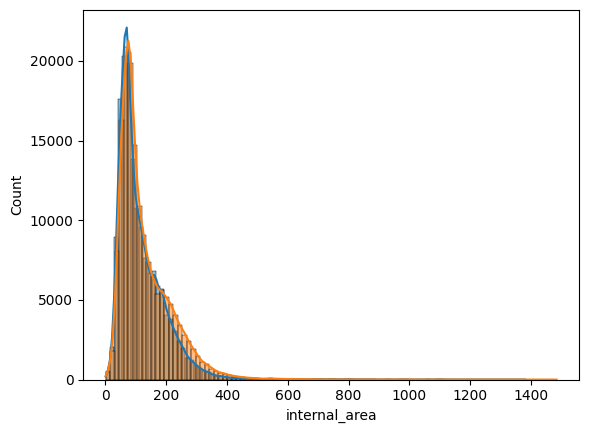

In [19]:
sns.histplot(data = df, x = 'internal_area', bins=100, kde=True, alpha=0.5)
sns.histplot(data = df, x = 'usable_area', bins=100, kde=True,alpha = 0.5)

In [32]:
df.head()

'303285584'

In [57]:
keys = [
        'oppussingsobjekt', 'oppussingsbehov', 'oppussingsklar','renoveringsobjekt','oppgraderingsobjekt',
        'renoveringsbehov', 'moderniseringsbehov','moderniseringsobjekt','oppgraderingsbehov','rehabilitering/oppussing', 'rehabilitering','oppussing'
        ]

regex = '|'.join(re.escape(key) for key in keys)
pattern = re.compile(regex, re.IGNORECASE)
test = df['description'].str.lower().str.contains(pattern, regex=True, na=False)